In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
pd.set_option('display.width', 1000)

import os
if not os.path.exists('visualisation'):
    os.makedirs('visualisation')
    

## 1. Data Loading and Preprocessing

In [2]:
df = pd.read_csv('all_teams_transition_data.csv')
df.head()

,loss_event_id,game_id,period_id,loss_time,team_losing_ball,team_gaining_ball,loss_x,loss_y,action_id,seconds_after_loss,team_id,team_name,player_id,player_name,action_type,result,start_x,start_y,end_x,end_y
0,11,5oc8drrbruovbuiriyhdyiyok,1,26.0,1oyb7oym5nwzny8vxf03szd2h,b7jmo07lqav0wfe2mtlzyspak,49.77,24.14,12,1.0,b7jmo07lqav0wfe2mtlzyspak,Mechelen,7e0cr2upqlgq4btrm3h99bpey,B. Van den Eynden,10,1,70.560,32.232,70.560,32.232
1,11,5oc8drrbruovbuiriyhdyiyok,1,26.0,1oyb7oym5nwzny8vxf03szd2h,b7jmo07lqav0wfe2mtlzyspak,49.77,24.14,13,4.0,b7jmo07lqav0wfe2mtlzyspak,Mechelen,3eywxsna9qzi1egis1uj4l6mt,G. Hairemans,0,0,60.690,36.788,49.665,32.368
2,11,5oc8drrbruovbuiriyhdyiyok,1,26.0,1oyb7oym5nwzny8vxf03szd2h,b7jmo07lqav0wfe2mtlzyspak,49.77,24.14,14,6.0,1oyb7oym5nwzny8vxf03szd2h,Club Brugge,l6y4o9t2b0jxaxo85oztok45,B. Mechele,0,0,50.505,29.716,60.585,28.696
3,11,5oc8drrbruovbuiriyhdyiyok,1,26.0,1oyb7oym5nwzny8vxf03szd2h,b7jmo07lqav0wfe2mtlzyspak,49.77,24.14,15,7.0,b7jmo07lqav0wfe2mtlzyspak,Mechelen,25ey2mcvgwz6ls2612os5hzv9,R. Schoofs,0,0,60.900,29.512,34.860,37.128
4,11,5oc8drrbruovbuiriyhdyiyok,1,26.0,1oyb7oym5nwzny8vxf03szd2h,b7jmo07lqav0wfe2mtlzyspak,49.77,24.14,16,9.0,1oyb7oym5nwzny8vxf03szd2h,Club Brugge,buglwgk2hthoyqt1ocghya92i,Z. Romero,0,1,39.480,38.556,32.865,47.328


In [3]:
print(f"Dataset shape: {df.shape}")
print("\nColumn data types:")
df.dtypes

Dataset shape: (166832, 20)

Column data types:


loss_event_id         int64
game_id              object
period_id             int64
loss_time           float64
team_losing_ball     object
                     ...   
result                int64
start_x             float64
start_y             float64
end_x               float64
end_y               float64
Length: 20, dtype: object

In [4]:
numerical_cols = ['loss_event_id', 'period_id', 'loss_time', 'loss_x', 'loss_y', 
                 'action_id', 'seconds_after_loss', 'action_type', 'result',
                 'start_x', 'start_y', 'end_x', 'end_y']

for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Number of unique games: {df['game_id'].nunique()}")
print(f"Number of unique teams: {df['team_name'].nunique()}")
print(f"Number of unique players: {df['player_name'].nunique()}")
print(f"Number of unique transition events: {df['loss_event_id'].nunique()}")

Number of unique games: 137
Number of unique teams: 16
Number of unique players: 403
Number of unique transition events: 41534


In [5]:
def categorize_field_zone(x, y):

    if x < 35:
        x_zone = "Defensive Third"
    elif x < 70:
        x_zone = "Middle Third"
    else:
        x_zone = "Attacking Third"
    
    if y < 22.67:
        y_zone = "Left Wing"
    elif y < 45.33:
        y_zone = "Central"
    else:
        y_zone = "Right Wing"
    
    return f"{x_zone} - {y_zone}"

df['loss_zone'] = df.apply(lambda row: categorize_field_zone(row['loss_x'], row['loss_y']), axis=1)

loss_zone_counts = df.groupby('loss_zone')['loss_event_id'].nunique()
print("\nDistribution of ball losses by field zone:")
loss_zone_counts.sort_values(ascending=False)


Distribution of ball losses by field zone:


loss_zone
Middle Third - Right Wing       5808
Middle Third - Left Wing        5733
Attacking Third - Central       5120
Defensive Third - Central       4490
Attacking Third - Right Wing    4446
Attacking Third - Left Wing     4360
Defensive Third - Right Wing    4054
Defensive Third - Left Wing     3930
Middle Third - Central          3593
Name: loss_event_id, dtype: int64

## 2. Creating Football Pitch Drawing Function

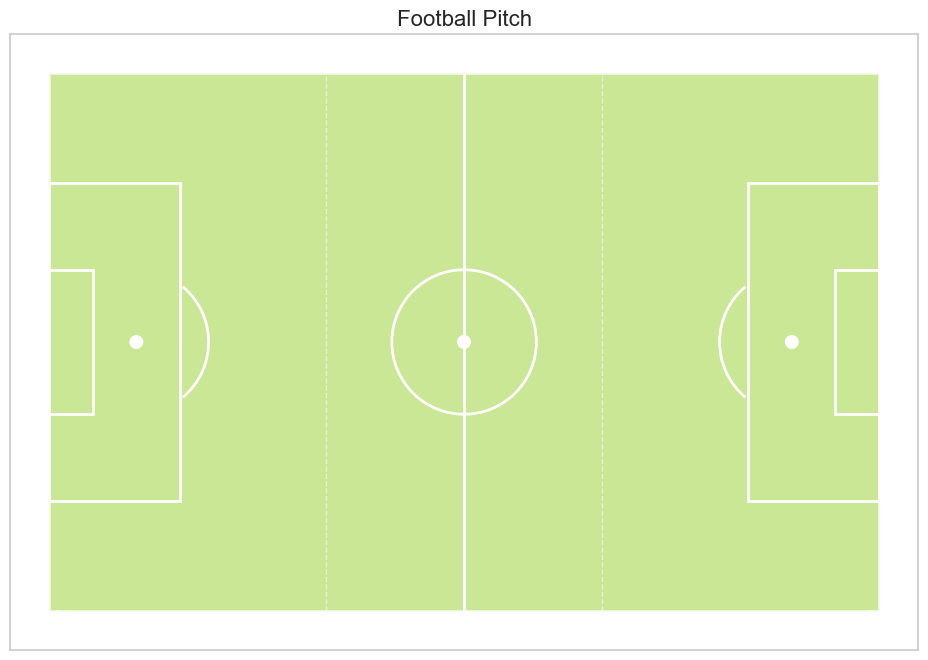

In [6]:
def draw_pitch(ax, pitch_color='#B3DE69', line_color='white', pitch_width=105, pitch_height=68):
    rect = patches.Rectangle((0, 0), pitch_width, pitch_height, linewidth=2, 
                             edgecolor=line_color, facecolor=pitch_color, alpha=0.7, zorder=0)
    ax.add_patch(rect)
    
    ax.plot([pitch_width/2, pitch_width/2], [0, pitch_height], color=line_color, linewidth=2, zorder=1)
    
    center_circle = patches.Circle((pitch_width/2, pitch_height/2), 9.15, 
                                   fill=False, color=line_color, linewidth=2, zorder=1)
    ax.add_patch(center_circle)
    
    center_spot = patches.Circle((pitch_width/2, pitch_height/2), 0.8, 
                                color=line_color, zorder=1)
    ax.add_patch(center_spot)
    
    left_penalty = patches.Rectangle((0, (pitch_height - 40.32)/2), 16.5, 40.32, 
                                     linewidth=2, edgecolor=line_color, facecolor='none', zorder=1)
    ax.add_patch(left_penalty)
    
    right_penalty = patches.Rectangle((pitch_width - 16.5, (pitch_height - 40.32)/2), 16.5, 40.32, 
                                      linewidth=2, edgecolor=line_color, facecolor='none', zorder=1)
    ax.add_patch(right_penalty)
    
    left_goal_area = patches.Rectangle((0, (pitch_height - 18.32)/2), 5.5, 18.32, 
                                       linewidth=2, edgecolor=line_color, facecolor='none', zorder=1)
    ax.add_patch(left_goal_area)
    
    right_goal_area = patches.Rectangle((pitch_width - 5.5, (pitch_height - 18.32)/2), 5.5, 18.32, 
                                        linewidth=2, edgecolor=line_color, facecolor='none', zorder=1)
    ax.add_patch(right_goal_area)
    
    left_penalty_spot = patches.Circle((11, pitch_height/2), 0.8, color=line_color, zorder=1)
    ax.add_patch(left_penalty_spot)
    
    right_penalty_spot = patches.Circle((pitch_width - 11, pitch_height/2), 0.8, color=line_color, zorder=1)
    ax.add_patch(right_penalty_spot)
    
    left_arc = patches.Arc((11, pitch_height/2), 18.3, 18.3, 
                          theta1=310, theta2=50, linewidth=2, color=line_color, zorder=1)
    ax.add_patch(left_arc)
    
    right_arc = patches.Arc((pitch_width - 11, pitch_height/2), 18.3, 18.3, 
                           theta1=130, theta2=230, linewidth=2, color=line_color, zorder=1)
    ax.add_patch(right_arc)
    
    top_left_corner = patches.Arc((0, pitch_height), 2, 2, 
                                 theta1=0, theta2=90, linewidth=2, color=line_color, zorder=1)
    ax.add_patch(top_left_corner)
    
    bottom_left_corner = patches.Arc((0, 0), 2, 2, 
                                    theta1=270, theta2=360, linewidth=2, color=line_color, zorder=1)
    ax.add_patch(bottom_left_corner)
    
    top_right_corner = patches.Arc((pitch_width, pitch_height), 2, 2, 
                                  theta1=90, theta2=180, linewidth=2, color=line_color, zorder=1)
    ax.add_patch(top_right_corner)
    
    bottom_right_corner = patches.Arc((pitch_width, 0), 2, 2, 
                                     theta1=180, theta2=270, linewidth=2, color=line_color, zorder=1)
    ax.add_patch(bottom_right_corner)
    
    ax.set_xlim(-5, pitch_width + 5)
    ax.set_ylim(-5, pitch_height + 5)
    ax.set_aspect('equal')
    
    ax.set_xticks([])
    ax.set_yticks([])

    ax.plot([35, 35], [0, pitch_height], color=line_color, linestyle='--', alpha=0.5, linewidth=1, zorder=1)
    ax.plot([70, 70], [0, pitch_height], color=line_color, linestyle='--', alpha=0.5, linewidth=1, zorder=1)
    
    return ax

fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)
plt.title('Football Pitch', fontsize=16)
plt.show()

## 3. Ball Loss Analysis

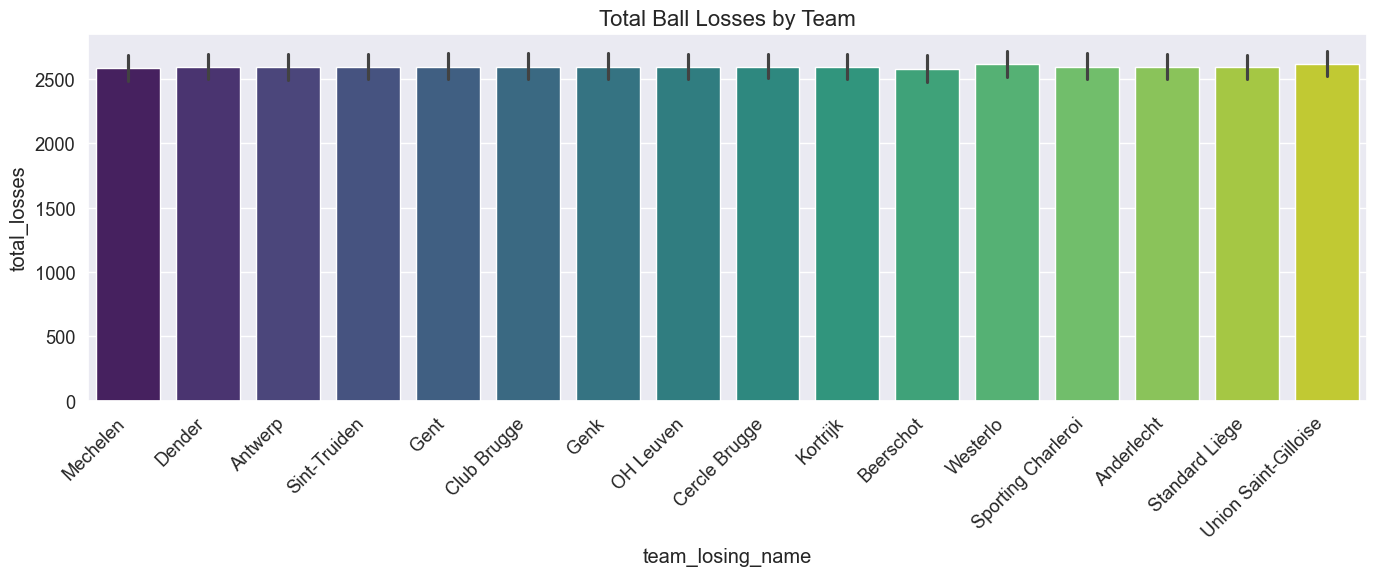

In [31]:
team_losses = df.groupby('team_losing_ball')['loss_event_id'].nunique().reset_index()
team_losses = team_losses.merge(df[['team_losing_ball', 'team_name']].drop_duplicates(), 
                             on='team_losing_ball', how='left')
team_losses = team_losses.rename(columns={'team_name': 'team_losing_name', 'loss_event_id': 'total_losses'})
team_losses = team_losses.sort_values('total_losses', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='team_losing_name', y='total_losses', data=team_losses, palette='viridis')
plt.title('Total Ball Losses by Team', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualisation/total_ball_losses_by_team.png', dpi=300, bbox_inches='tight')
plt.show()

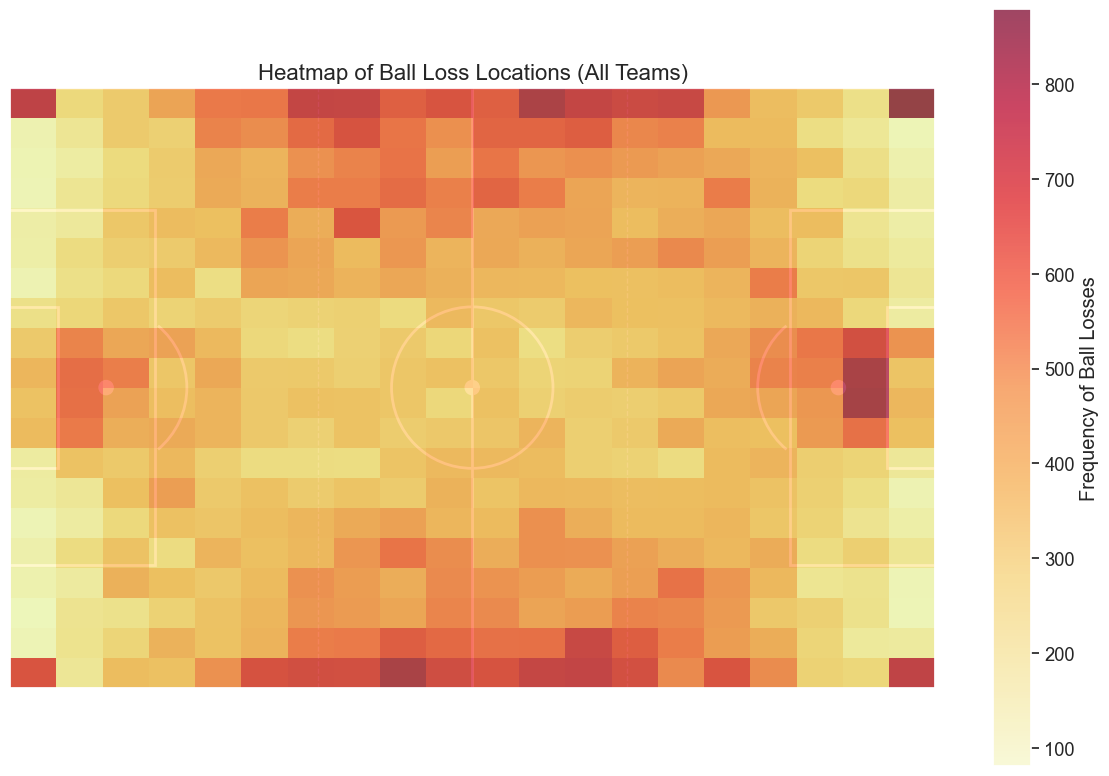

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)

x = df['loss_x']
y = df['loss_y']

h = ax.hist2d(x, y, bins=20, cmap='YlOrRd', alpha=0.7, zorder=2)

plt.colorbar(h[3], ax=ax, label='Frequency of Ball Losses')
ax.set_title('Heatmap of Ball Loss Locations (All Teams)', fontsize=16)
plt.tight_layout()
plt.savefig('visualisation/ball_loss_heatmap_all_teams.png', dpi=300, bbox_inches='tight')
plt.show()

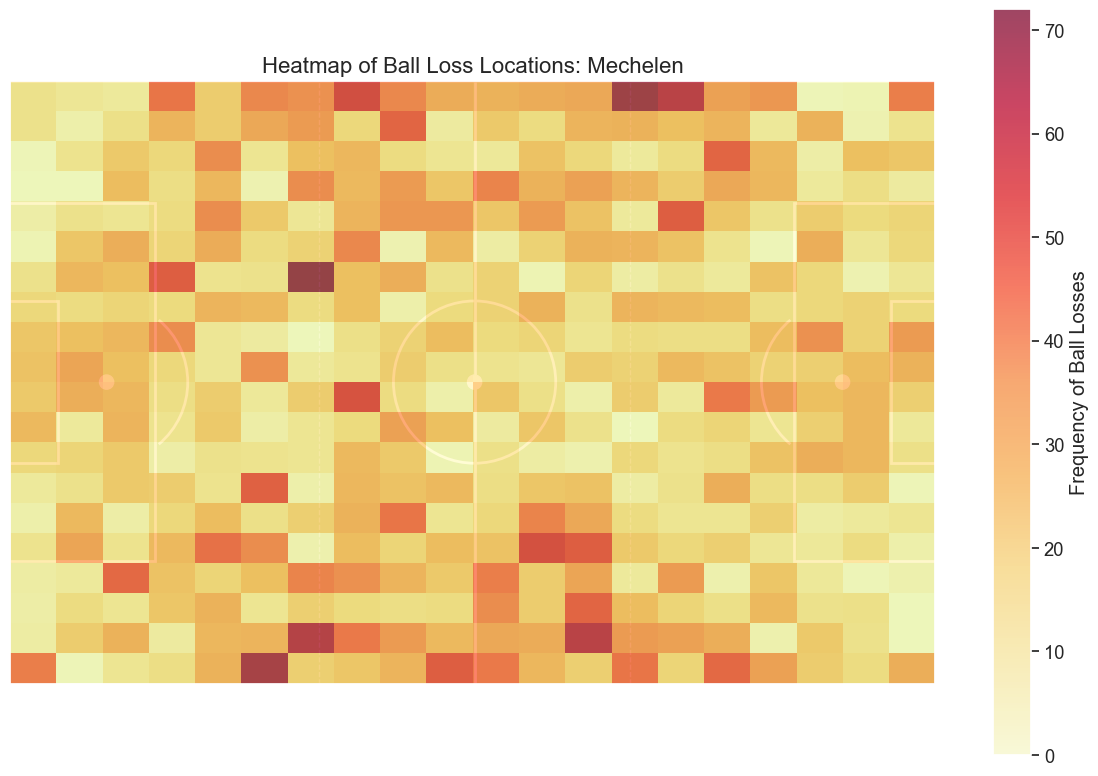

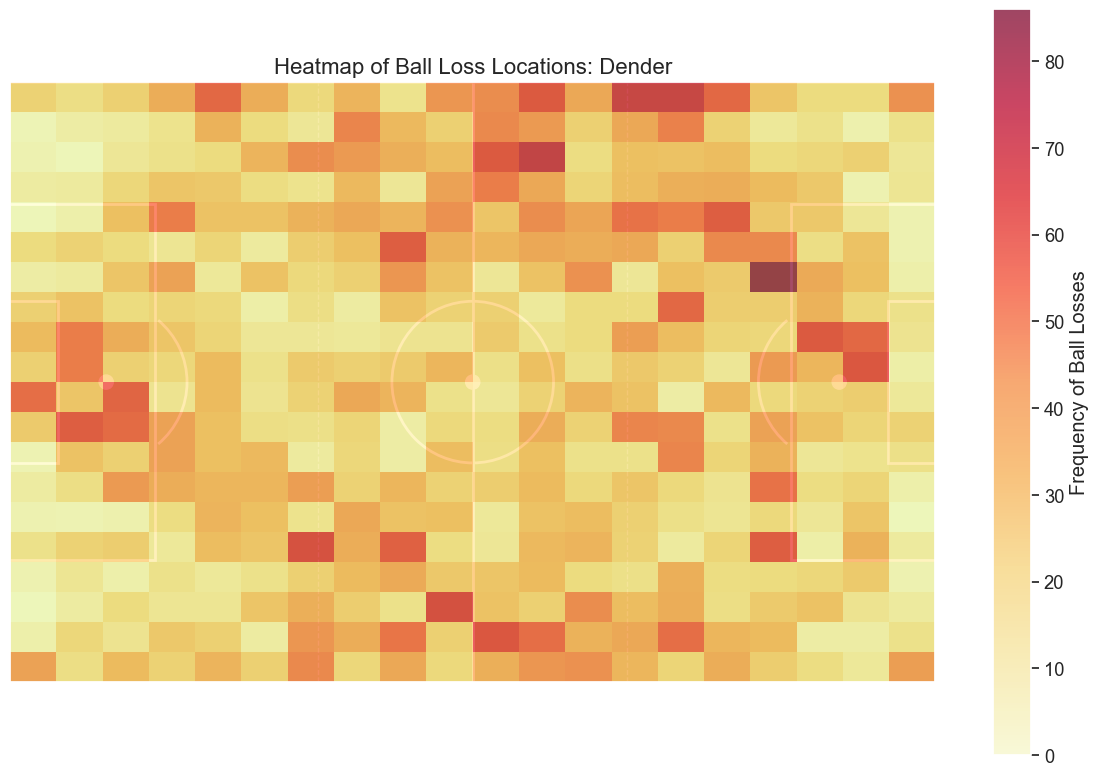

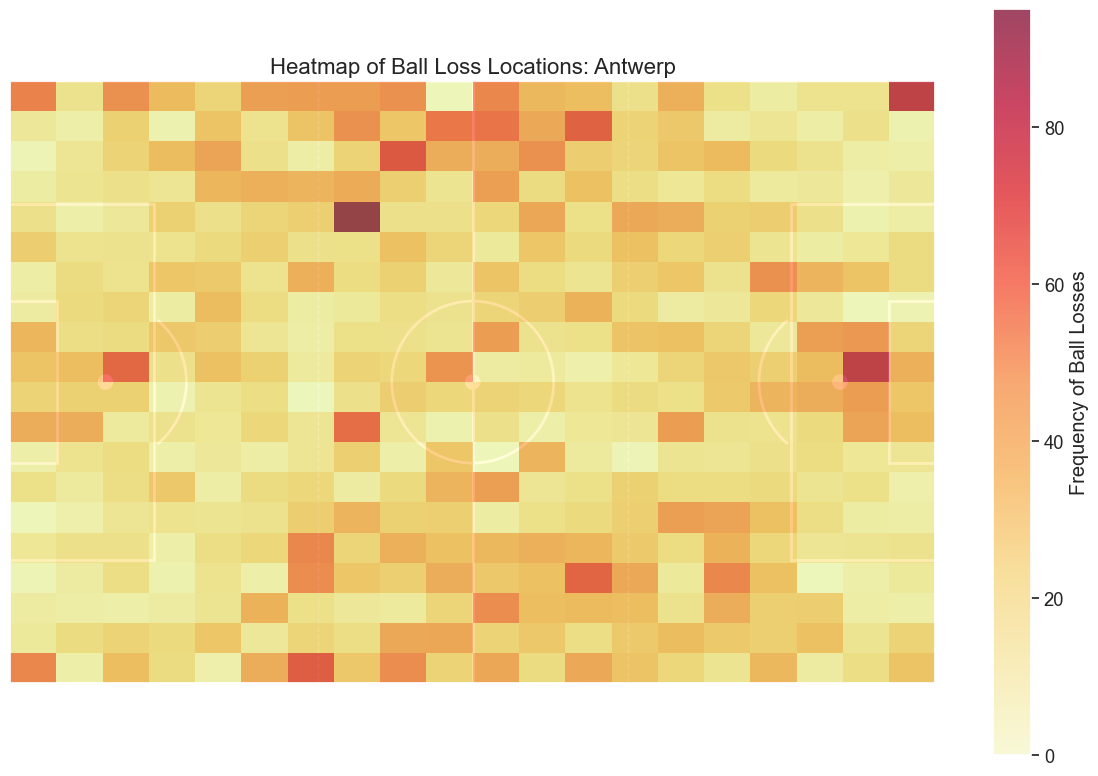

In [33]:
def plot_team_ball_losses(team_name, df, n_teams=1):
    team_id = df[df['team_name'] == team_name]['team_id'].iloc[0]
    team_data = df[df['team_losing_ball'] == team_id]
    
    if n_teams == 1:
        fig, ax = plt.subplots(figsize=(12, 8))
        draw_pitch(ax)
        
        h = ax.hist2d(team_data['loss_x'], team_data['loss_y'], bins=20, cmap='YlOrRd', alpha=0.7, zorder=2)
        plt.colorbar(h[3], ax=ax, label='Frequency of Ball Losses')
        
        ax.set_title(f'Heatmap of Ball Loss Locations: {team_name}', fontsize=16)
        
    return ax

top_loss_teams = team_losses.head(3)['team_losing_name'].tolist()

for team in top_loss_teams:
    plot_team_ball_losses(team, df)
    plt.tight_layout()
    plt.savefig(f'visualisation/ball_loss_heatmap_{team}.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Transition Sequence Analysis

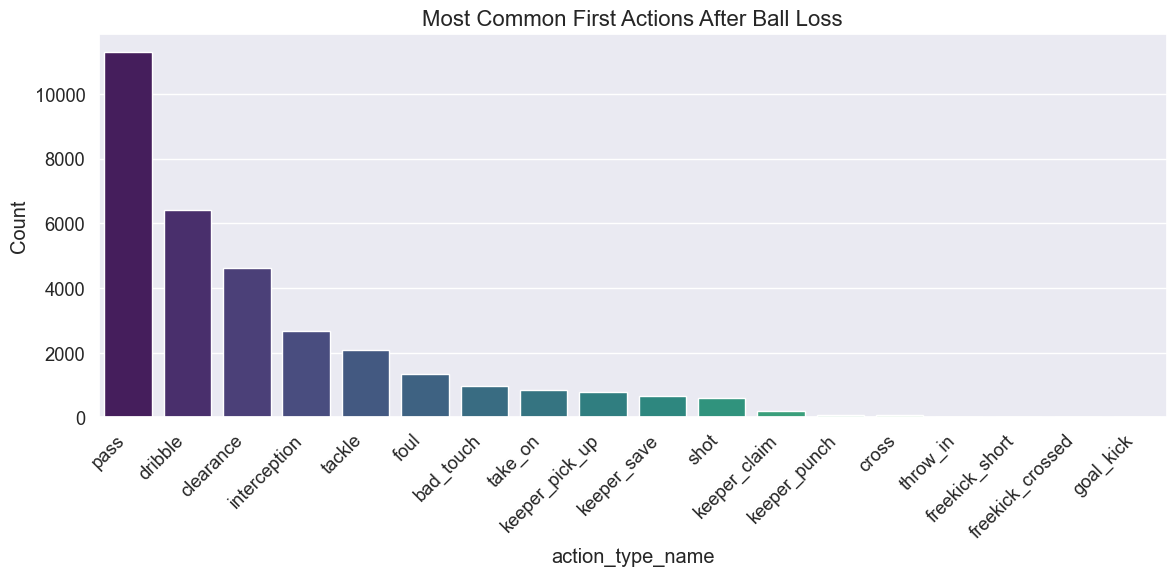

In [34]:
action_type_map = {
    0: "pass",
    1: "cross",
    2: "throw_in",
    3: "freekick_crossed",
    4: "freekick_short",
    5: "corner_crossed",
    6: "corner_short",
    7: "take_on",
    8: "foul",
    9: "tackle",
    10: "interception",
    11: "shot",
    12: "shot_penalty",
    13: "shot_freekick",
    14: "keeper_save",
    15: "keeper_claim",
    16: "keeper_punch",
    17: "keeper_pick_up",
    18: "clearance",
    19: "bad_touch",
    20: "non_action",
    21: "dribble",
    22: "goal_kick"
}

df['action_type_name'] = df['action_type'].map(action_type_map)

first_actions = df[df['seconds_after_loss'] <= 2].copy()
first_action_counts = first_actions.groupby('action_type_name')['loss_event_id'].count().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=first_action_counts.index, y=first_action_counts.values, palette='viridis')
plt.title('Most Common First Actions After Ball Loss', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('visualisation/first_actions_after_loss.png', dpi=300, bbox_inches='tight')
plt.show()

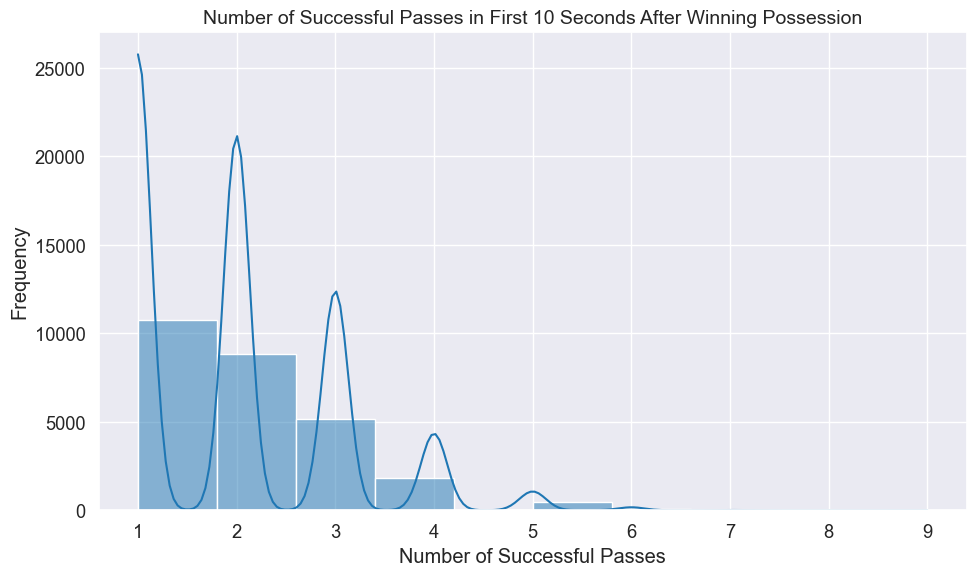

In [35]:
successful_passes = df[(df['action_type_name'] == 'pass') & (df['result'] == 1)]
passes_per_transition = successful_passes.groupby('loss_event_id')['action_id'].count().reset_index()
passes_per_transition.columns = ['loss_event_id', 'num_successful_passes']

plt.figure(figsize=(10, 6))
sns.histplot(passes_per_transition['num_successful_passes'], kde=True, bins=10)
plt.title('Number of Successful Passes in First 10 Seconds After Winning Possession', fontsize=14)
plt.xlabel('Number of Successful Passes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('visualisation/successful_passes_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Transition Event ID: 205165


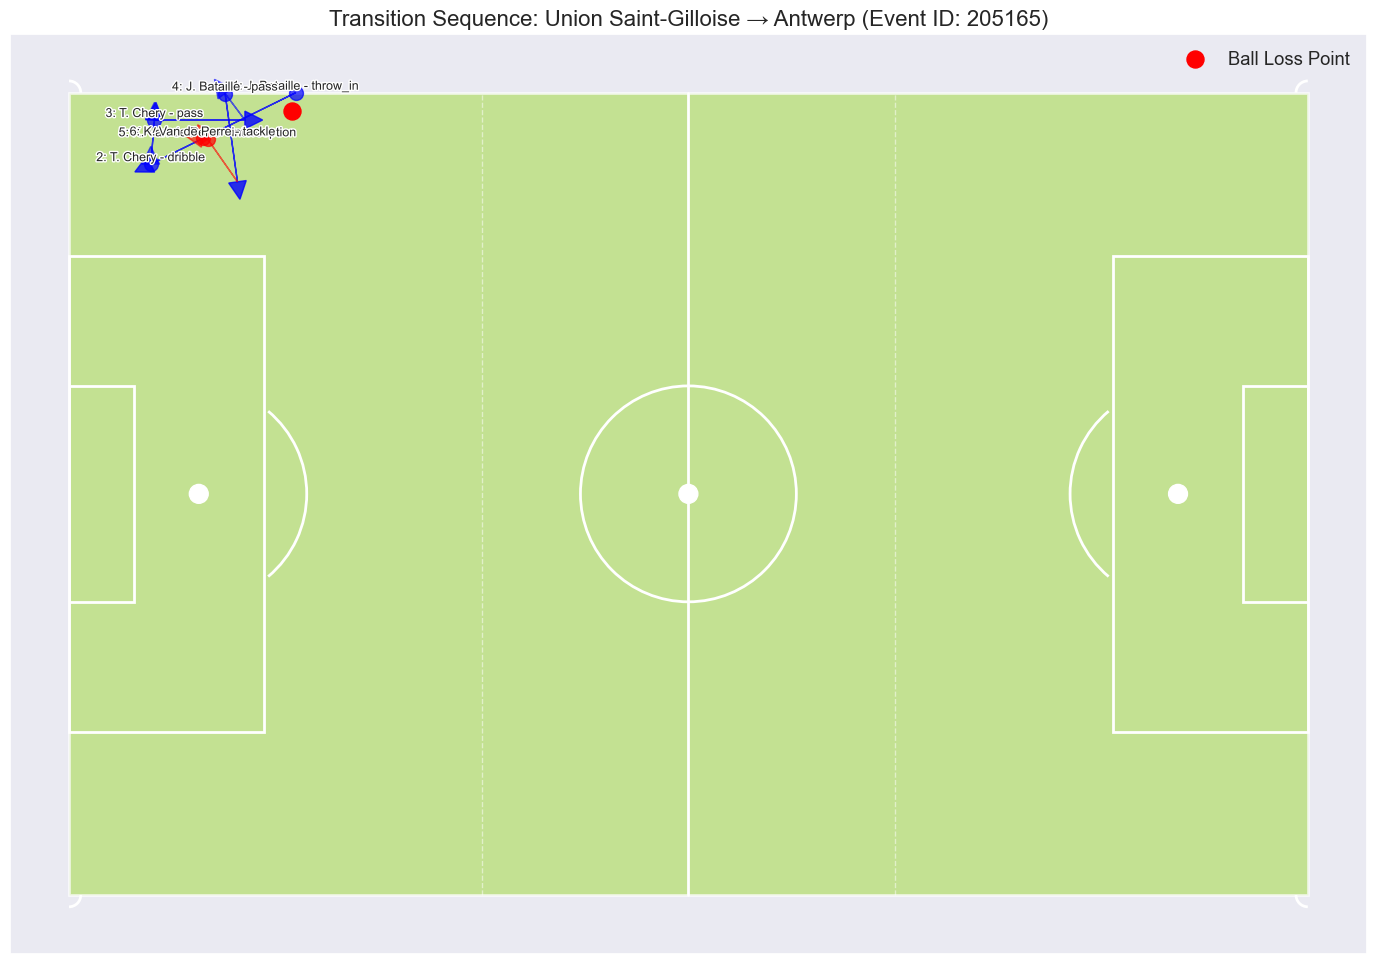


Sequence Details:


,seconds_after_loss,team_name,player_name,action_type_name,result,start_x,start_y,end_x,end_y
130726,5.0,Antwerp,J. Bataille,throw_in,1,19.215,68.000,6.930,61.948
130727,6.0,Antwerp,T. Chery,dribble,1,6.930,61.948,7.245,65.688
130728,7.0,Antwerp,T. Chery,pass,1,7.245,65.688,14.910,65.688
130729,8.0,Antwerp,J. Bataille,pass,0,13.230,67.932,14.280,60.452
130730,8.0,Union Saint-Gilloise,K. Van de Perre,interception,1,11.760,64.056,11.760,64.056
130731,10.0,Union Saint-Gilloise,K. Van de Perre,tackle,0,11.340,64.124,11.340,64.124



Transition Event ID: 2276


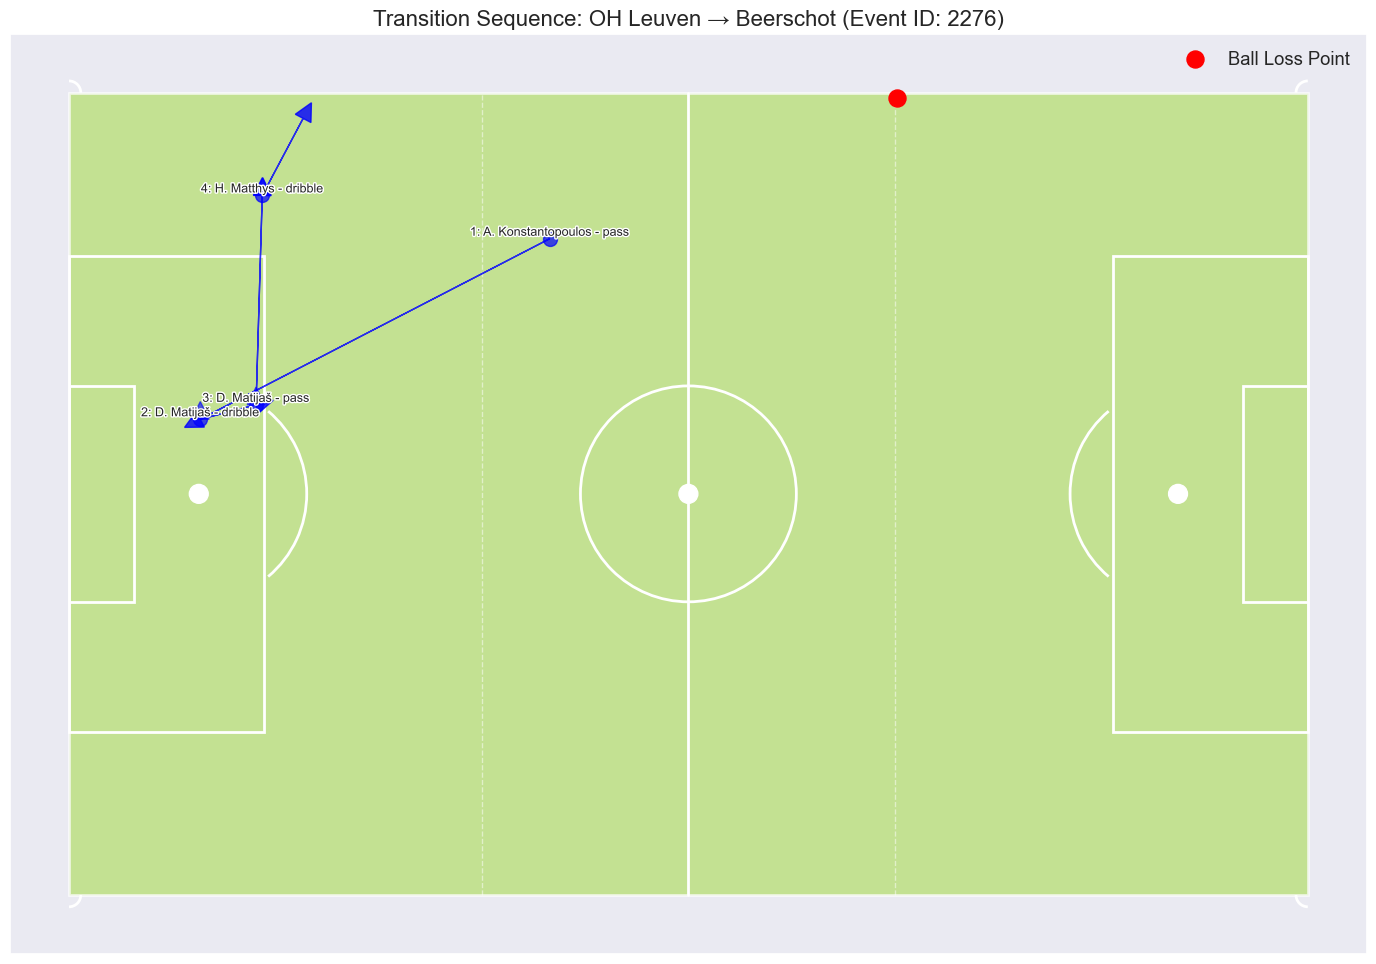


Sequence Details:


,seconds_after_loss,team_name,player_name,action_type_name,result,start_x,start_y,end_x,end_y
133572,4.0,Beerschot,A. Konstantopoulos,pass,1,40.740,55.624,11.130,40.324
133573,5.5,Beerschot,D. Matijaš,dribble,1,11.130,40.324,15.855,41.548
133574,7.0,Beerschot,D. Matijaš,pass,1,15.855,41.548,16.380,59.296
133575,9.0,Beerschot,H. Matthys,dribble,1,16.380,59.296,19.845,65.824



Transition Event ID: 163898


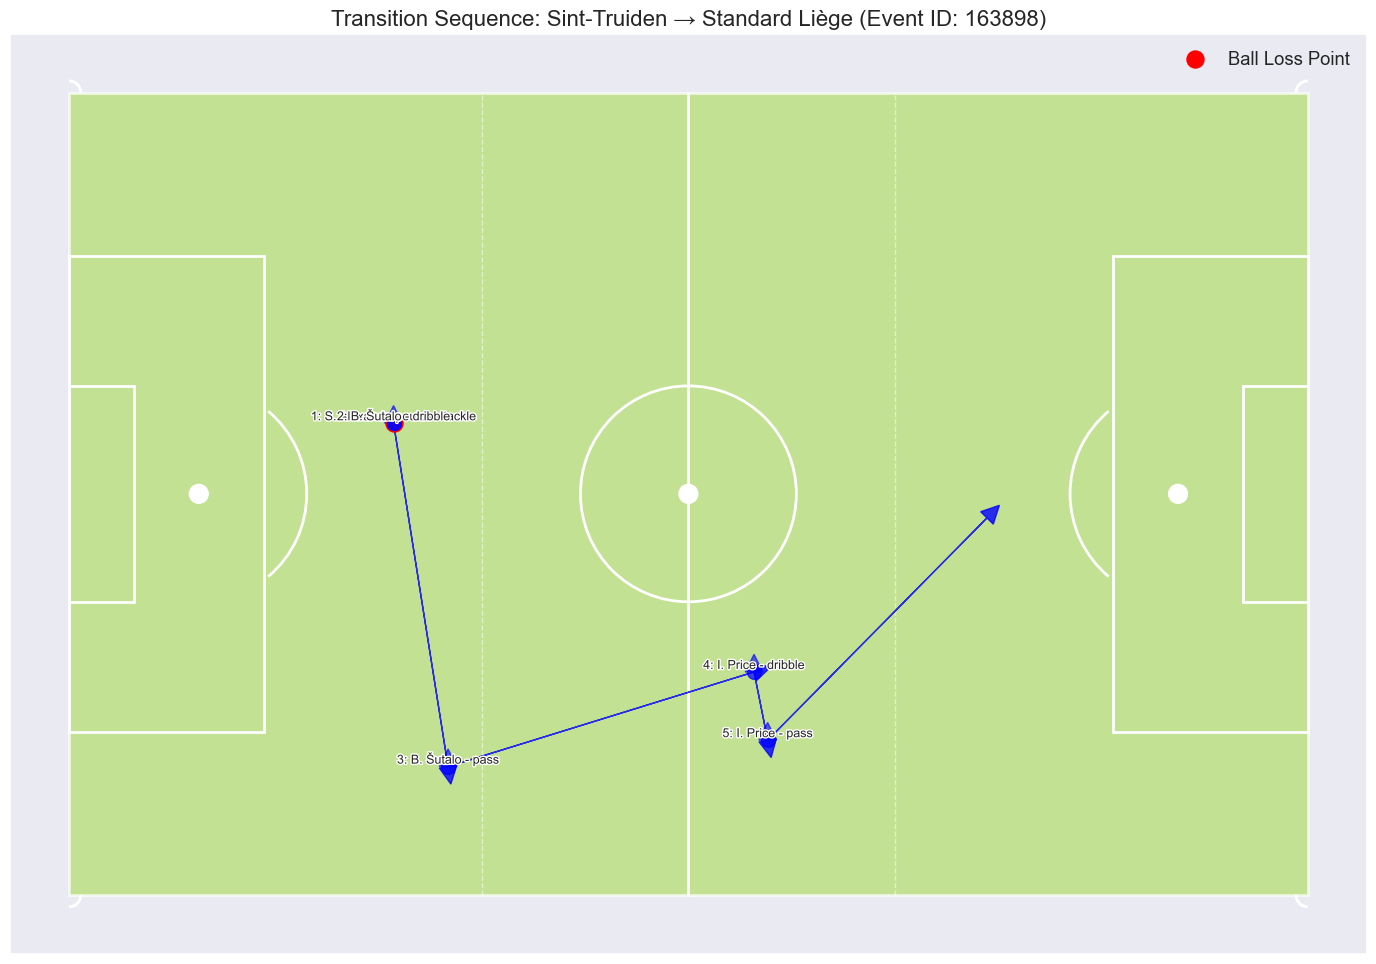


Sequence Details:


,seconds_after_loss,team_name,player_name,action_type_name,result,start_x,start_y,end_x,end_y
119252,1.0,Standard Liège,S. Alexandropoulos,tackle,1,27.510,39.984,27.510,39.984
119253,3.0,Standard Liège,B. Šutalo,dribble,1,27.510,39.984,32.130,10.880
119254,5.0,Standard Liège,B. Šutalo,pass,1,32.130,10.880,58.065,18.904
119255,7.0,Standard Liège,I. Price,dribble,1,58.065,18.904,59.220,13.124
119256,9.0,Standard Liège,I. Price,pass,2,59.220,13.124,77.805,31.960


In [36]:
def visualize_transition_sequence(loss_event_id, df):
    event_data = df[df['loss_event_id'] == loss_event_id].sort_values('seconds_after_loss')
    
    if len(event_data) == 0:
        print(f"No data found for loss event ID {loss_event_id}")
        return
    
    team_losing = event_data['team_losing_ball'].iloc[0]
    team_gaining = event_data['team_gaining_ball'].iloc[0]
    
    team_losing_name = df[df['team_id'] == team_losing]['team_name'].iloc[0]
    team_gaining_name = df[df['team_id'] == team_gaining]['team_name'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    draw_pitch(ax)
    
    loss_x = event_data['loss_x'].iloc[0]
    loss_y = event_data['loss_y'].iloc[0]
    ax.scatter(loss_x, loss_y, color='red', s=150, zorder=3, label='Ball Loss Point')
    
    for i, (_, action) in enumerate(event_data.iterrows()):
        team_color = 'blue' if action['team_id'] == team_gaining else 'red'
        
        ax.scatter(action['start_x'], action['start_y'], color=team_color, 
                   s=100, alpha=0.7, zorder=3)
        
        if i > 0:
            prev_action = event_data.iloc[i-1]
            ax.arrow(prev_action['end_x'], prev_action['end_y'], 
                     action['start_x'] - prev_action['end_x'], 
                     action['start_y'] - prev_action['end_y'], 
                     head_width=1.5, head_length=1.5, fc=team_color, ec=team_color, 
                     alpha=0.6, zorder=2)
        
        if action['end_x'] != action['start_x'] or action['end_y'] != action['start_y']:
            ax.arrow(action['start_x'], action['start_y'], 
                    action['end_x'] - action['start_x'], 
                    action['end_y'] - action['start_y'], 
                    head_width=1.5, head_length=1.5, fc=team_color, ec=team_color, 
                    alpha=0.8, zorder=2)
        
        label_text = f"{i+1}: {action['player_name']} - {action['action_type_name']}"
        text = ax.text(action['start_x'], action['start_y'], label_text, 
                       fontsize=9, ha='center', va='bottom', zorder=4)
        text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])
    
    ax.legend(loc='upper right')
    ax.set_title(f"Transition Sequence: {team_losing_name} → {team_gaining_name} (Event ID: {loss_event_id})", 
                fontsize=16)
    
    plt.tight_layout()
    plt.savefig(f'visualisation/transition_sequence_{loss_event_id}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nSequence Details:")
    display(event_data[['seconds_after_loss', 'team_name', 'player_name', 'action_type_name', 'result', 
                        'start_x', 'start_y', 'end_x', 'end_y']])

sample_loss_events = df['loss_event_id'].sample(3).unique()

for event_id in sample_loss_events:
    print(f"\n{'='*80}\nTransition Event ID: {event_id}\n{'='*80}")
    visualize_transition_sequence(event_id, df)

## 5. Team Transition Performance Analysis

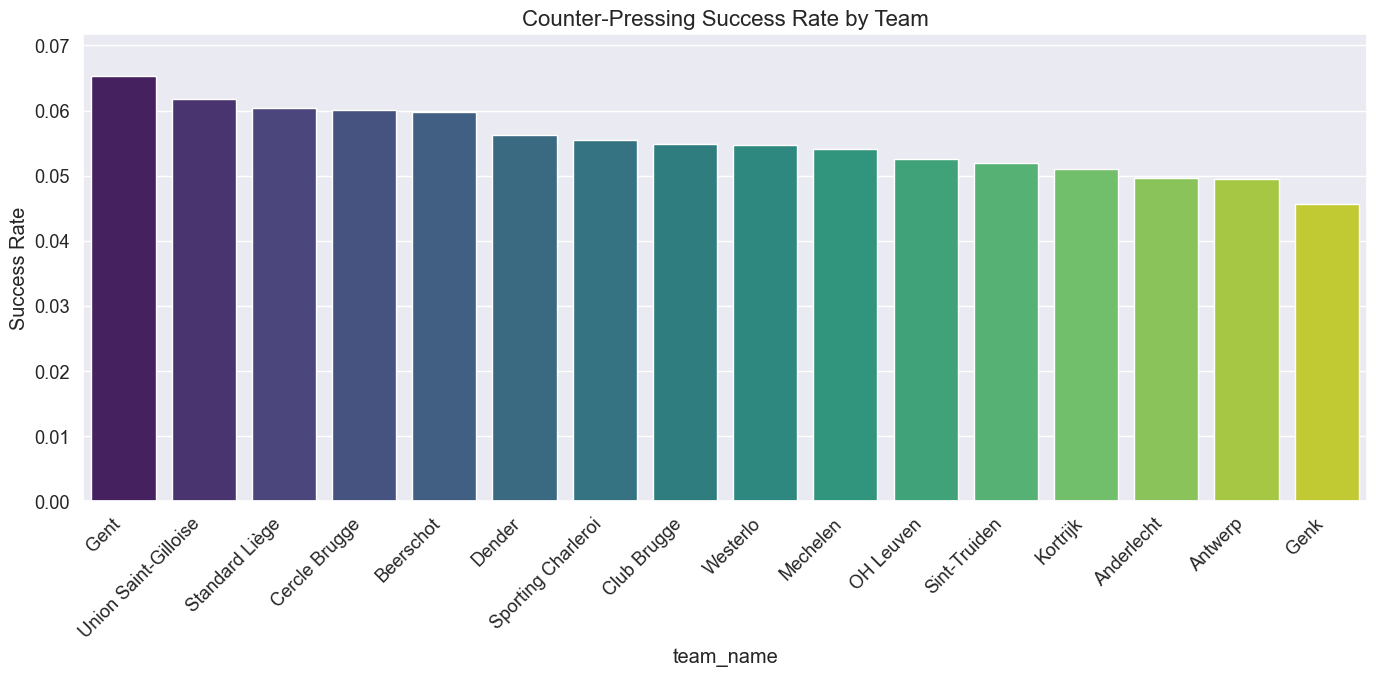

In [37]:
defensive_actions = ['interception', 'tackle', 'keeper_save', 'keeper_claim', 'keeper_punch', 'keeper_pick_up', 'clearance']

counter_press_data = []

for team_id in df['team_losing_ball'].unique():
    team_losses = df[df['team_losing_ball'] == team_id]['loss_event_id'].unique()
    
    successful_counter_presses = 0
    
    for loss_id in team_losses:
        actions = df[(df['loss_event_id'] == loss_id) & 
                     (df['team_id'] == team_id) & 
                     (df['seconds_after_loss'] <= 5)]
        
        if any((actions['action_type_name'].isin(defensive_actions)) & (actions['result'] == 1)):
            successful_counter_presses += 1
    
    counter_press_rate = successful_counter_presses / len(team_losses) if len(team_losses) > 0 else 0
    
    team_name = df[df['team_id'] == team_id]['team_name'].iloc[0]
    
    counter_press_data.append({
        'team_id': team_id,
        'team_name': team_name,
        'total_losses': len(team_losses),
        'successful_counter_presses': successful_counter_presses,
        'counter_press_rate': counter_press_rate
    })

counter_press_df = pd.DataFrame(counter_press_data)
counter_press_df = counter_press_df.sort_values('counter_press_rate', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x='team_name', y='counter_press_rate', data=counter_press_df, palette='viridis')
plt.title('Counter-Pressing Success Rate by Team', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Success Rate')
plt.ylim(0, counter_press_df['counter_press_rate'].max() * 1.1)  # Add a little space at the top
plt.tight_layout()
plt.savefig('visualisation/counter_press_success_rate.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1400x700 with 0 Axes>

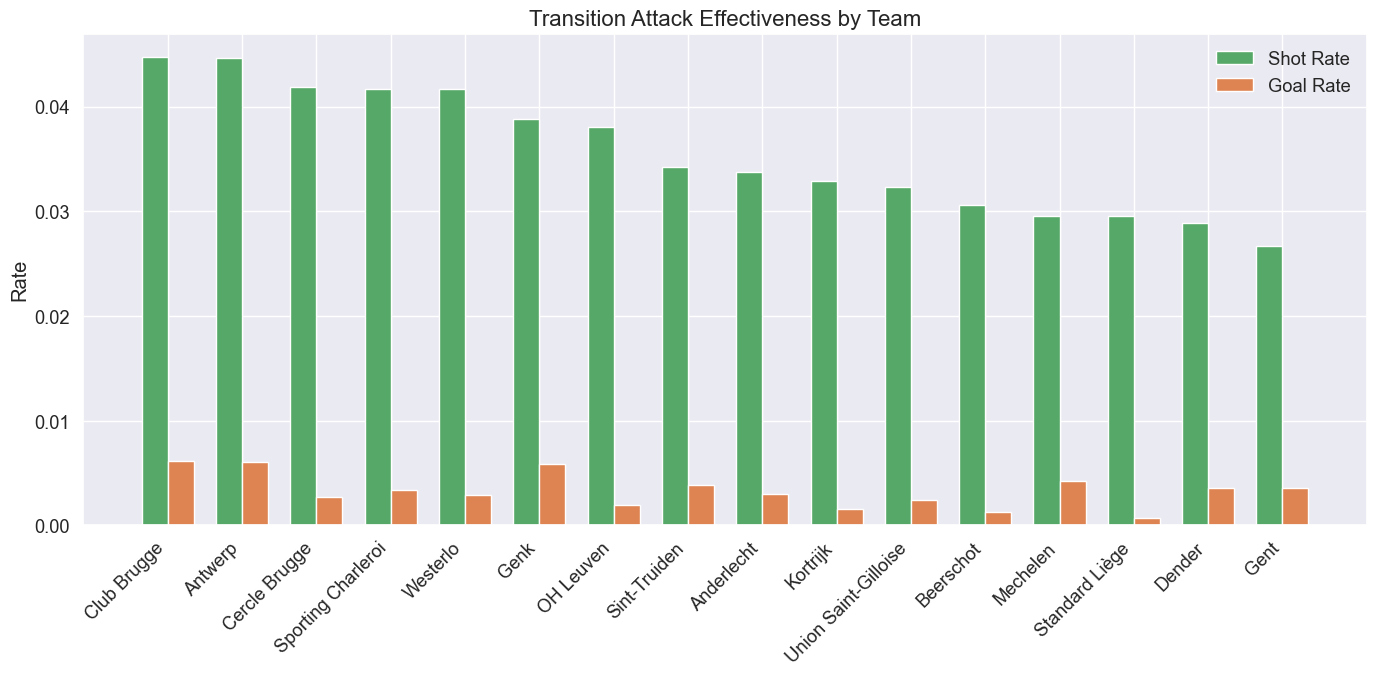

In [38]:
shot_actions = ['shot', 'shot_penalty', 'shot_freekick']

transition_attack_data = []

for team_id in df['team_gaining_ball'].unique():
    team_gains = df[df['team_gaining_ball'] == team_id]['loss_event_id'].unique()
    
    transitions_with_shots = 0
    transitions_with_goals = 0
    
    for gain_id in team_gains:
        actions = df[(df['loss_event_id'] == gain_id) & 
                     (df['team_id'] == team_id) & 
                     (df['seconds_after_loss'] <= 10)]
        
        shot_actions_in_transition = actions[actions['action_type_name'].isin(shot_actions)]
        
        if len(shot_actions_in_transition) > 0:
            transitions_with_shots += 1
            
            if any(shot_actions_in_transition['result'] == 1):
                transitions_with_goals += 1
    
    shot_rate = transitions_with_shots / len(team_gains) if len(team_gains) > 0 else 0
    goal_rate = transitions_with_goals / len(team_gains) if len(team_gains) > 0 else 0
    
    team_name = df[df['team_id'] == team_id]['team_name'].iloc[0]
    
    transition_attack_data.append({
        'team_id': team_id,
        'team_name': team_name,
        'total_gains': len(team_gains),
        'transitions_with_shots': transitions_with_shots,
        'transitions_with_goals': transitions_with_goals,
        'shot_rate': shot_rate,
        'goal_rate': goal_rate
    })

transition_attack_df = pd.DataFrame(transition_attack_data)
transition_attack_df = transition_attack_df.sort_values('shot_rate', ascending=False)

plt.figure(figsize=(14, 7))

x = np.arange(len(transition_attack_df))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, transition_attack_df['shot_rate'], width, label='Shot Rate', color='#55a868')
rects2 = ax.bar(x + width/2, transition_attack_df['goal_rate'], width, label='Goal Rate', color='#DD8452')

ax.set_ylabel('Rate')
ax.set_title('Transition Attack Effectiveness by Team', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(transition_attack_df['team_name'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('visualisation/transition_attack_effectiveness.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Player Analysis in Transitions

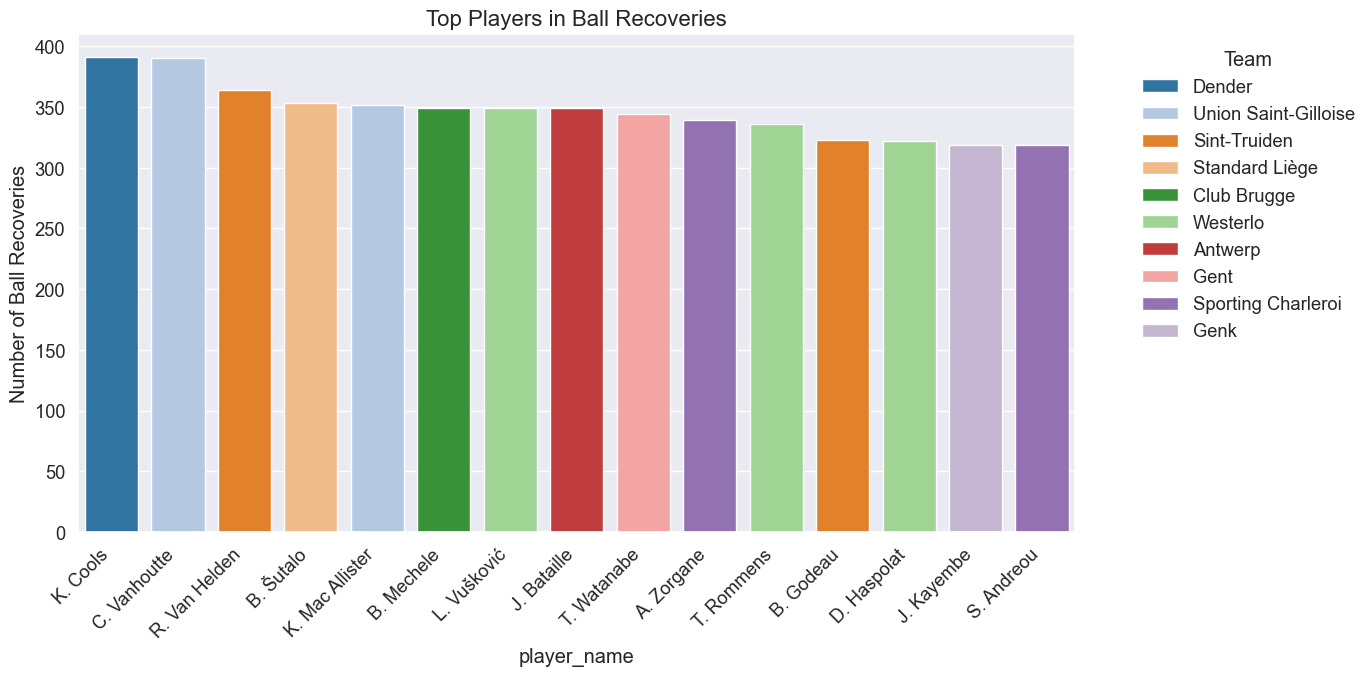

In [40]:
first_recovery_actions = df.groupby('loss_event_id').apply(lambda x: x[x['seconds_after_loss'] == x['seconds_after_loss'].min()])
first_recovery_actions = first_recovery_actions.reset_index(drop=True)

player_recoveries = first_recovery_actions.groupby(['player_id', 'player_name', 'team_name'])['loss_event_id'].count().reset_index()
player_recoveries.columns = ['player_id', 'player_name', 'team_name', 'recovery_count']
player_recoveries = player_recoveries.sort_values('recovery_count', ascending=False)

plt.figure(figsize=(14, 7))
top_recovery_players = player_recoveries.head(15)
sns.barplot(x='player_name', y='recovery_count', hue='team_name', data=top_recovery_players, dodge=False, palette='tab20')
plt.title('Top Players in Ball Recoveries', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Ball Recoveries')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('visualisation/top_players_in_recoveries.png', dpi=300, bbox_inches='tight')
plt.show()

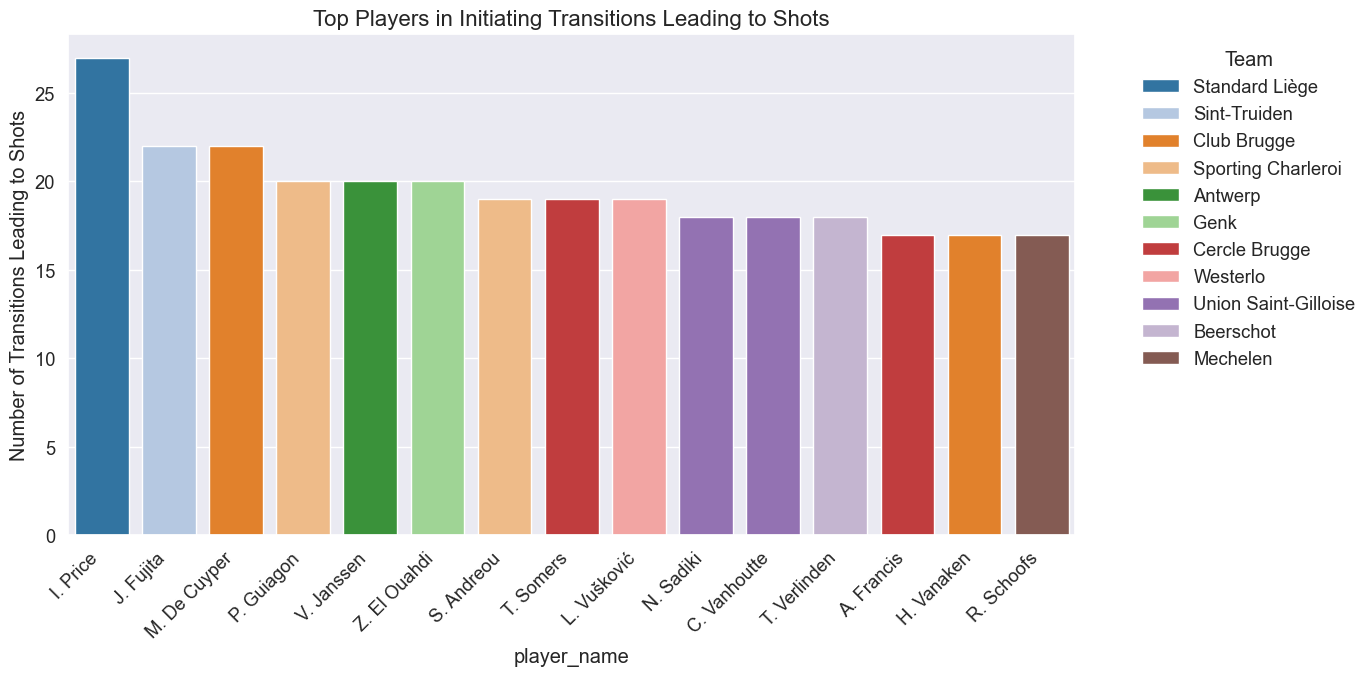

In [39]:
transitions_with_shots = df[df['action_type_name'].isin(shot_actions)]['loss_event_id'].unique()

first_actions_leading_to_shots = []

for event_id in transitions_with_shots:
    event_actions = df[df['loss_event_id'] == event_id].sort_values('seconds_after_loss')
    if not event_actions.empty:
        first_actions_leading_to_shots.append(event_actions.iloc[0])

first_actions_df = pd.DataFrame(first_actions_leading_to_shots)

player_initiated_shots = first_actions_df.groupby(['player_id', 'player_name', 'team_name'])['loss_event_id'].count().reset_index()
player_initiated_shots.columns = ['player_id', 'player_name', 'team_name', 'transitions_to_shots']
player_initiated_shots = player_initiated_shots.sort_values('transitions_to_shots', ascending=False)

plt.figure(figsize=(14, 7))
top_transition_players = player_initiated_shots.head(15)
sns.barplot(x='player_name', y='transitions_to_shots', hue='team_name', data=top_transition_players, dodge=False, palette='tab20')
plt.title('Top Players in Initiating Transitions Leading to Shots', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Transitions Leading to Shots')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('visualisation/top_players_initiating_transitions.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Advanced Transition Pathways Visualization

Let's create a visualization that shows the most common transition pathways on the pitch.

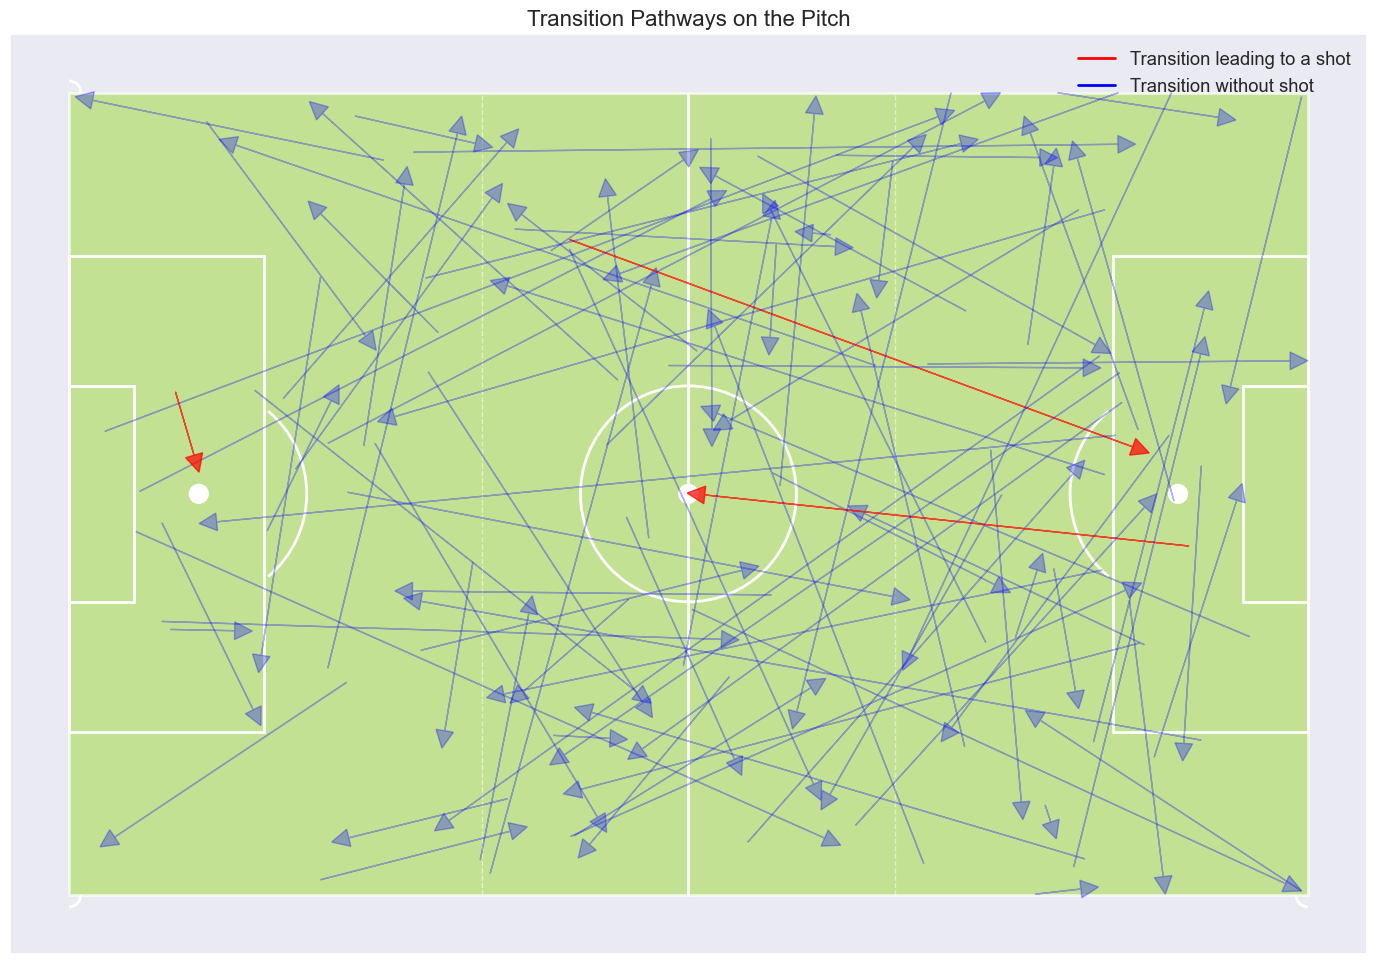

In [41]:
transition_pathways = []

for event_id in df['loss_event_id'].unique():
    event_data = df[df['loss_event_id'] == event_id].sort_values('seconds_after_loss')
    
    if len(event_data) >= 2:  # Need at least two actions to form a pathway
        start_x = event_data['loss_x'].iloc[0]
        start_y = event_data['loss_y'].iloc[0]
        
        end_x = event_data['end_x'].iloc[-1]
        end_y = event_data['end_y'].iloc[-1]
        
        team_losing = event_data['team_losing_ball'].iloc[0]
        team_gaining = event_data['team_gaining_ball'].iloc[0]
        
        distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
        
        shot_in_transition = any(event_data['action_type_name'].isin(shot_actions))
        
        transition_pathways.append({
            'loss_event_id': event_id,
            'team_losing': team_losing,
            'team_gaining': team_gaining,
            'start_x': start_x,
            'start_y': start_y,
            'end_x': end_x,
            'end_y': end_y,
            'distance': distance,
            'shot_in_transition': shot_in_transition
        })

transition_pathways_df = pd.DataFrame(transition_pathways)

transition_pathways_df['direction_angle'] = np.degrees(np.arctan2(
    transition_pathways_df['end_y'] - transition_pathways_df['start_y'],
    transition_pathways_df['end_x'] - transition_pathways_df['start_x']
))

fig, ax = plt.subplots(figsize=(14, 10))
draw_pitch(ax)

for _, pathway in transition_pathways_df.sample(min(100, len(transition_pathways_df))).iterrows():
    color = 'red' if pathway['shot_in_transition'] else 'blue'
    alpha = 0.7 if pathway['shot_in_transition'] else 0.3
    
    ax.arrow(pathway['start_x'], pathway['start_y'],
             pathway['end_x'] - pathway['start_x'], pathway['end_y'] - pathway['start_y'],
             head_width=1.5, head_length=1.5, fc=color, ec=color, alpha=alpha, zorder=2,
             length_includes_head=True)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Transition leading to a shot'),
    Line2D([0], [0], color='blue', lw=2, label='Transition without shot')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('Transition Pathways on the Pitch', fontsize=16)
plt.tight_layout()
plt.savefig('visualisation/transition_pathways.png', dpi=300, bbox_inches='tight')
plt.show()

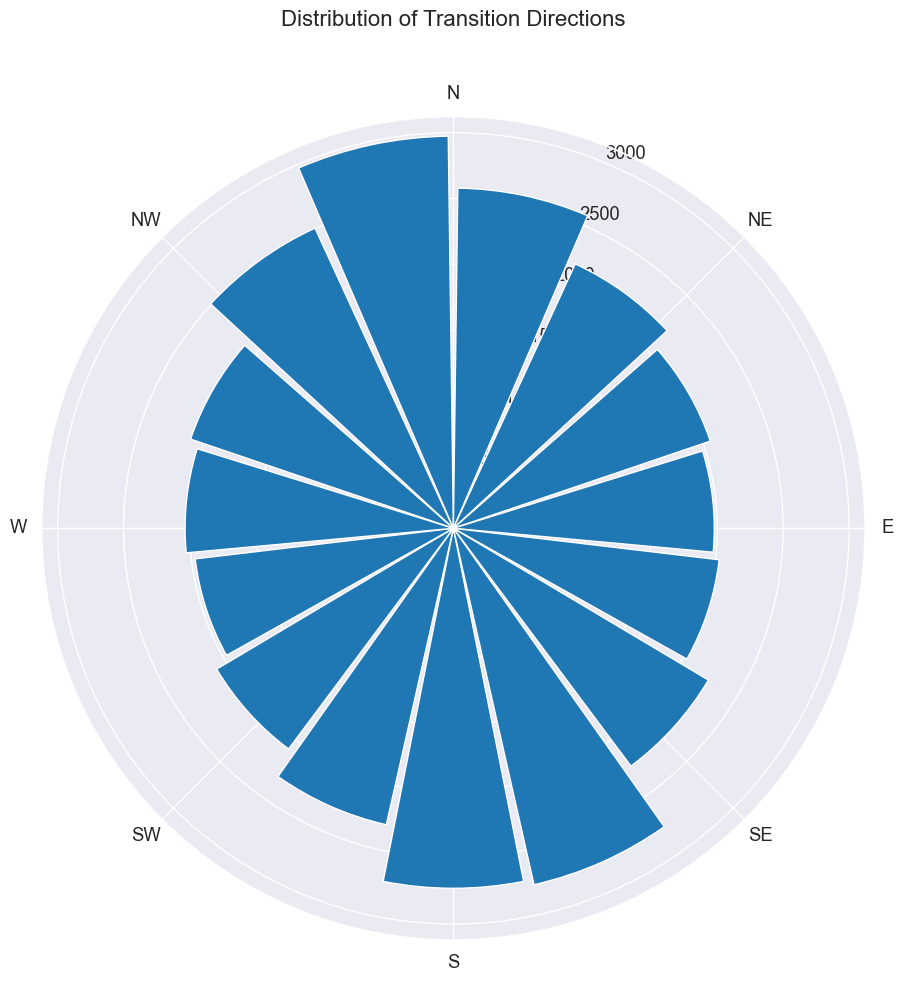

In [42]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')

angles = np.radians(transition_pathways_df['direction_angle'])

bins = np.linspace(-np.pi, np.pi, 16)
counts, _ = np.histogram(angles, bins=bins)

width = 2*np.pi / len(bins)
bars = ax.bar(bins[:-1], counts, width=width, bottom=0.0)

ax.set_theta_zero_location('N')  # Set 0 degrees to north
ax.set_theta_direction(-1)  # Clockwise
ax.set_title('Distribution of Transition Directions', fontsize=16, y=1.1)

ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

plt.tight_layout()
plt.savefig('visualisation/transition_directions.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Team Comparison Dashboard

Let's create a comprehensive dashboard to compare two teams' transition performance.

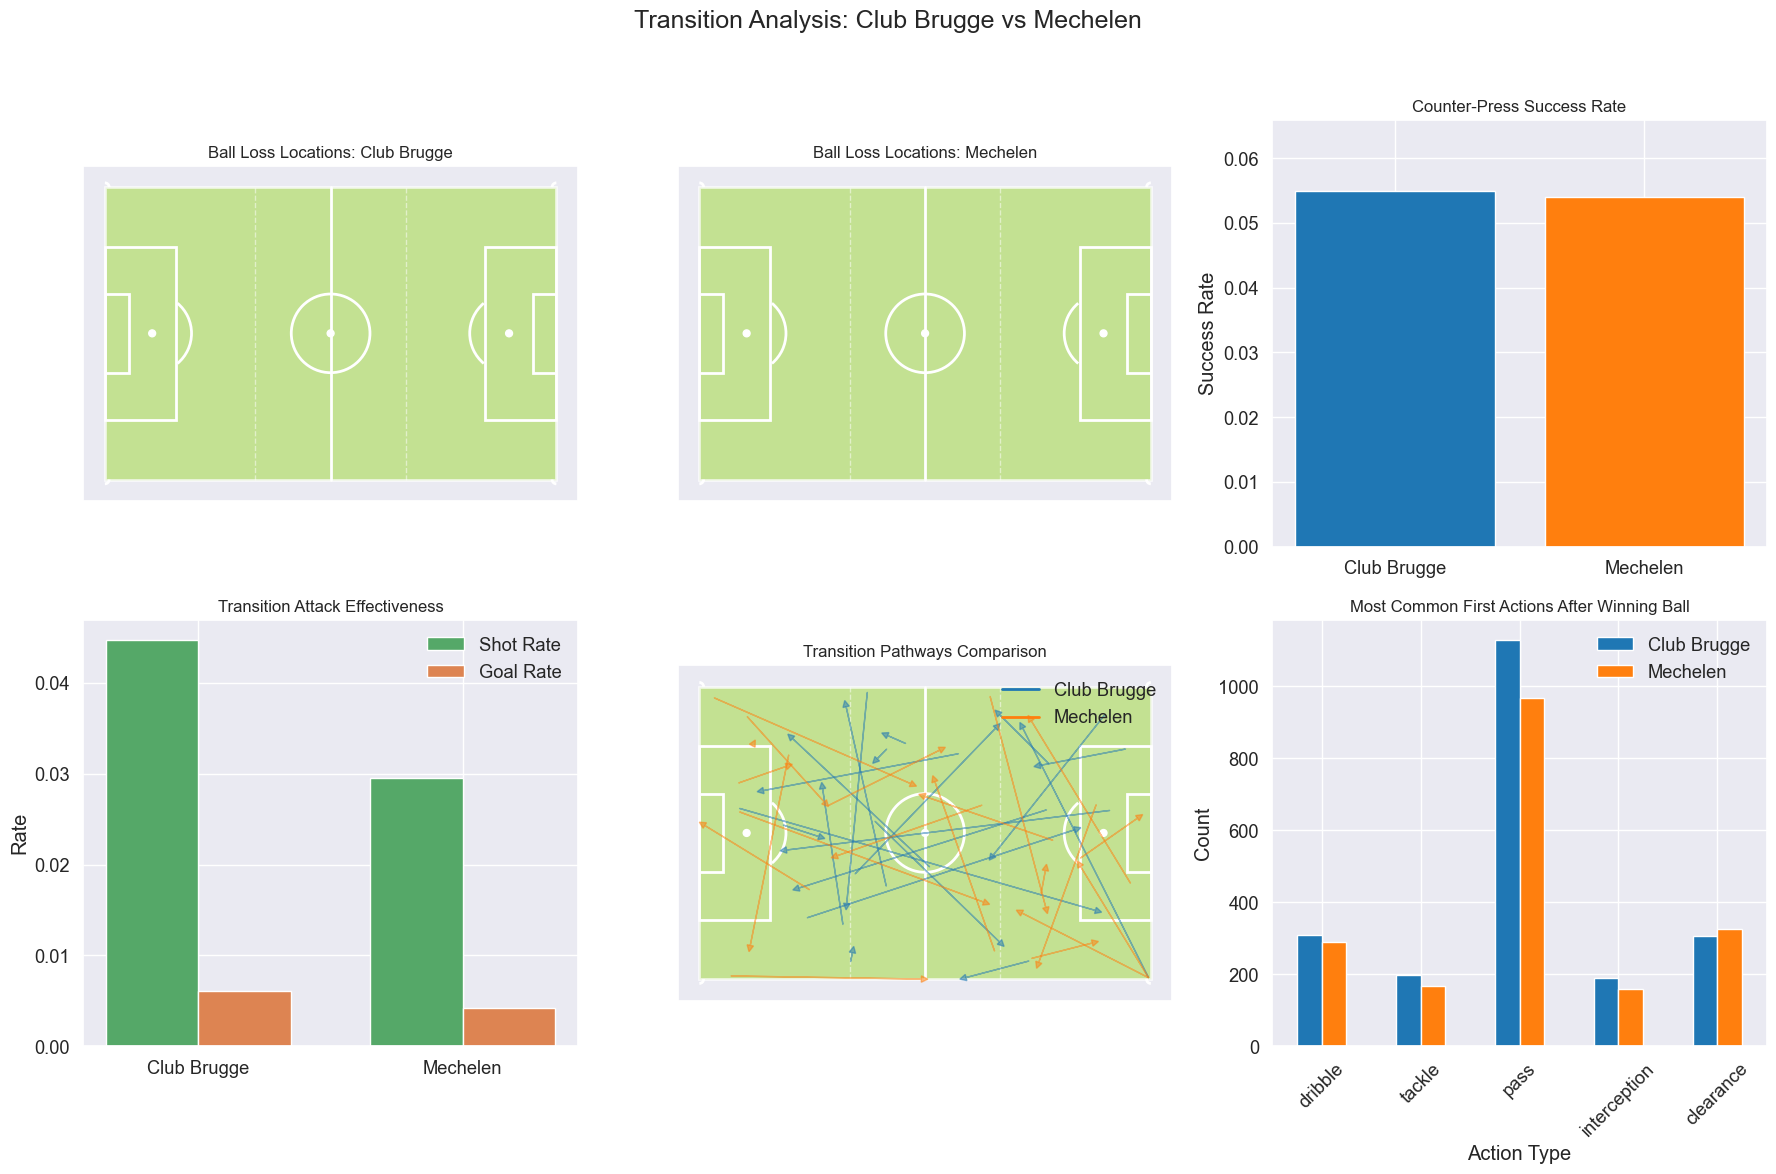

In [43]:
def create_team_comparison_dashboard(team1_name, team2_name, df, save_path=None):
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.lines import Line2D
    import numpy as np
    import pandas as pd
    
    team1_id = df[df['team_name'] == team1_name]['team_id'].iloc[0]
    team2_id = df[df['team_name'] == team2_name]['team_id'].iloc[0]
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1])
    
    ax1 = fig.add_subplot(gs[0, 0])
    draw_pitch(ax1)
    ax1.set_title(f'Ball Loss Locations: {team1_name}', fontsize=12)
    
    ax2 = fig.add_subplot(gs[0, 1])
    draw_pitch(ax2)
    ax2.set_title(f'Ball Loss Locations: {team2_name}', fontsize=12)
    
    team1_cp_rate = counter_press_df[counter_press_df['team_name'] == team1_name]['counter_press_rate'].iloc[0]
    team2_cp_rate = counter_press_df[counter_press_df['team_name'] == team2_name]['counter_press_rate'].iloc[0]
    
    ax3 = fig.add_subplot(gs[0, 2])
    teams = [team1_name, team2_name]
    cp_rates = [team1_cp_rate, team2_cp_rate]
    colors = ['#1f77b4', '#ff7f0e']  # Blue and orange
    ax3.bar(teams, cp_rates, color=colors)
    ax3.set_ylim(0, max(cp_rates) * 1.2)
    ax3.set_title('Counter-Press Success Rate', fontsize=12)
    ax3.set_ylabel('Success Rate')
    
    team1_shot_rate = transition_attack_df[transition_attack_df['team_name'] == team1_name]['shot_rate'].iloc[0]
    team1_goal_rate = transition_attack_df[transition_attack_df['team_name'] == team1_name]['goal_rate'].iloc[0]
    team2_shot_rate = transition_attack_df[transition_attack_df['team_name'] == team2_name]['shot_rate'].iloc[0]
    team2_goal_rate = transition_attack_df[transition_attack_df['team_name'] == team2_name]['goal_rate'].iloc[0]
    
    ax4 = fig.add_subplot(gs[1, 0])
    x = np.arange(len(teams))
    width = 0.35
    ax4.bar(x - width/2, [team1_shot_rate, team2_shot_rate], width, label='Shot Rate', color='#55a868')
    ax4.bar(x + width/2, [team1_goal_rate, team2_goal_rate], width, label='Goal Rate', color='#DD8452')
    ax4.set_xticks(x)
    ax4.set_xticklabels(teams)
    ax4.set_title('Transition Attack Effectiveness', fontsize=12)
    ax4.set_ylabel('Rate')
    ax4.legend()
    
    ax5 = fig.add_subplot(gs[1, 1])
    draw_pitch(ax5)
    
    team1_pathways = transition_pathways_df[transition_pathways_df['team_gaining'] == team1_id]
    for _, pathway in team1_pathways.sample(min(20, len(team1_pathways))).iterrows():
        ax5.arrow(pathway['start_x'], pathway['start_y'],
                 pathway['end_x'] - pathway['start_x'], pathway['end_y'] - pathway['start_y'],
                 head_width=1.5, head_length=1.5, fc='#1f77b4', ec='#1f77b4', alpha=0.5, zorder=2,
                 length_includes_head=True)
    
    team2_pathways = transition_pathways_df[transition_pathways_df['team_gaining'] == team2_id]
    for _, pathway in team2_pathways.sample(min(20, len(team2_pathways))).iterrows():
        ax5.arrow(pathway['start_x'], pathway['start_y'],
                 pathway['end_x'] - pathway['start_x'], pathway['end_y'] - pathway['start_y'],
                 head_width=1.5, head_length=1.5, fc='#ff7f0e', ec='#ff7f0e', alpha=0.5, zorder=2,
                 length_includes_head=True)
    
    ax5.set_title('Transition Pathways Comparison', fontsize=12)
    
    legend_elements = [
        Line2D([0], [0], color='#1f77b4', lw=2, label=team1_name),
        Line2D([0], [0], color='#ff7f0e', lw=2, label=team2_name)
    ]
    ax5.legend(handles=legend_elements, loc='upper right')
    
    ax6 = fig.add_subplot(gs[1, 2])
    
    team1_first_recovery = first_recovery_actions[first_recovery_actions['team_id'] == team1_id]['action_type_name'].value_counts().head(5)
    team2_first_recovery = first_recovery_actions[first_recovery_actions['team_id'] == team2_id]['action_type_name'].value_counts().head(5)
    
    common_actions = list(set(team1_first_recovery.index) | set(team2_first_recovery.index))
    first_actions_comparison = pd.DataFrame(index=common_actions, columns=[team1_name, team2_name])
    
    for action in common_actions:
        first_actions_comparison.loc[action, team1_name] = team1_first_recovery.get(action, 0)
        first_actions_comparison.loc[action, team2_name] = team2_first_recovery.get(action, 0)
    
    first_actions_comparison.plot(kind='bar', ax=ax6)
    ax6.set_title('Most Common First Actions After Winning Ball', fontsize=12)
    ax6.set_ylabel('Count')
    ax6.set_xlabel('Action Type')
    ax6.tick_params(axis='x', rotation=45)
    
    fig.suptitle(f'Transition Analysis: {team1_name} vs {team2_name}', fontsize=18, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.savefig('visualisation/team_comparison_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

team1 = 'Club Brugge'
team2 = 'Mechelen'

create_team_comparison_dashboard(team1, team2, df)